# IceVision Bboxes - Real Data

*This is a mashup of IceVision's "[Custom Parser](https://airctic.com/0.8.0/custom_parser/)" example and their ["Getting Started (Object Detection)"](https://airctic.com/0.8.0/getting_started_object_detection/) notebooks, to analyze SPNet Real dataset, for which I [generated bounding boxes](https://github.com/drscotthawley/SPNet/blob/master/gen_bboxes_csv.py). -- S.H. Hawley, July 1, 2021*

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
#all_slow

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
#try:
#    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#    !chmod +x install_colab.sh && ./install_colab.sh
#except:
#    print("Ignore the error messages and just keep going")

In [ ]:
# system info
# probably want 
# pip3 install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
import torch, re 
tv, cv = torch.__version__, torch.version.cuda
tv = re.sub('\+cu.*','',tv)
TORCH_VERSION = 'torch'+tv[0:-1]+'0'
CUDA_VERSION = 'cu'+cv.replace('.','')

print(f"TORCH_VERSION={TORCH_VERSION}; CUDA_VERSION={CUDA_VERSION}")
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

TORCH_VERSION=torch1.8.0; CUDA_VERSION=cu102
1.8.1+cu102
True
1
0
NVIDIA GeForce RTX 2070 with Max-Q Design


In [ ]:
# For Icevision Install of MMD.  cf. https://airctic.com/0.8.1/install/
#!pip install -q mmcv-full=="1.3.8" -f https://download.openmmlab.com/mmcv/dist/{CUDA_VERSION}/{TORCH_VERSION}/index.html --upgrade
#!pip install -q mmdet

## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [ ]:
from icevision.all import *
import pandas as pd

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/shawley/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [ ]:
#data_url = "https://github.com/airctic/chess_sample/archive/master.zip"
#data_dir = icedata.load_data(data_url, 'chess_sample') / 'chess_sample-master'

# OLD SPNET Real Dataset link (currently proprietary, thus link may not work)
#data_url = "https://hedges.belmont.edu/~shawley/spnet_sample-master.zip"
#data_dir = icedata.load_data(data_url, 'spnet_sample') / 'spnet_sample-master' 

# espiownage cyclegan dataset: cyclegan is public for demo / reproducibility
#data_url = 'https://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz'
#data_dir = icedata.load_data(data_url, 'espiownage-cyclegan') / 'espiownage-cyclegan'

from pathlib import Path
data_dir = Path('/home/shawley/datasets/espiownage-cleaner') # real data is local and private.

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

!!! danger "Important"  
    Replace `source` with your own path for the dataset directory.

In [ ]:
df = pd.read_csv(data_dir / "bboxes/annotations.csv")
df.head()

filename  width  height  label  xmin  ymin  xmax  ymax
0  06240907_proc_00254.png    512     384      1    31   135   184   290
1  06240907_proc_00256.png    512     384      0    65   153   168   270
2  06240907_proc_00270.png    512     384      1    45   149   164   280
3  06240907_proc_00281.png    512     384     10     0   111   185   340
4  06240907_proc_00281.png    512     384      1   254   134   353   215

At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

In [ ]:
# *Let's just make them all the same object:
df['label'] = 'A'  # antinode
df.head()

filename  width  height label  xmin  ymin  xmax  ymax
0  06240907_proc_00254.png    512     384     A    31   135   184   290
1  06240907_proc_00256.png    512     384     A    65   153   168   270
2  06240907_proc_00270.png    512     384     A    45   149   164   280
3  06240907_proc_00281.png    512     384     A     0   111   185   340
4  06240907_proc_00281.png    512     384     A   254   134   353   215

## Create the Parser

The first step is to create a template record for our specific type of dataset, in this case we're doing standard object detection:

In [ ]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [ ]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

!!! danger "Important"  
    Be sure to pass the correct type on all record methods!

In [ ]:
# IceVision excample used "ChessParser" for chess data. For SPNet we could rename this class
# but currently not a priority!
class ChessParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "bboxes/annotations.csv")
        self.df['label'] = 'A'  # make them all the same object
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

Let's randomly split the data and parser with `Parser.parse`:

In [ ]:
parser = ChessParser(template_record, data_dir)

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/5161 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/1564 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Let's take a look at one record:

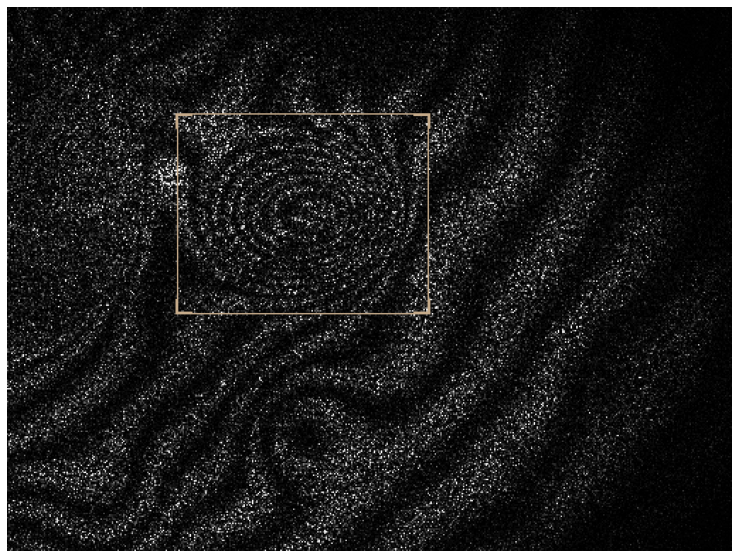

In [ ]:
show_record(train_records[5], display_label=False, figsize=(14, 10))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Image size ImgSize(width=512, height=384)
	- Filepath: /home/shawley/datasets/espiownage-cleaner/images/06240907_proc_01386.png
	- Img: None
	- Record ID: 657
detection: 
	- BBoxes: [<BBox (xmin:219, ymin:124, xmax:362, ymax:265)>, <BBox (xmin:228, ymin:11, xmax:271, ymax:84)>, <BBox (xmin:285, ymin:22, xmax:328, ymax:93)>, <BBox (xmin:0, ymin:106, xmax:167, ymax:321)>, <BBox (xmin:260, ymin:286, xmax:360, ymax:384)>]
	- Class Map: <ClassMap: {'background': 0, 'A': 1}>
	- Labels: [1, 1, 1, 1, 1]

## Moving On...
*Following the Getting Started "refrigerator" notebook...*

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384  
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### this next cell generates an error. ignore it and move on

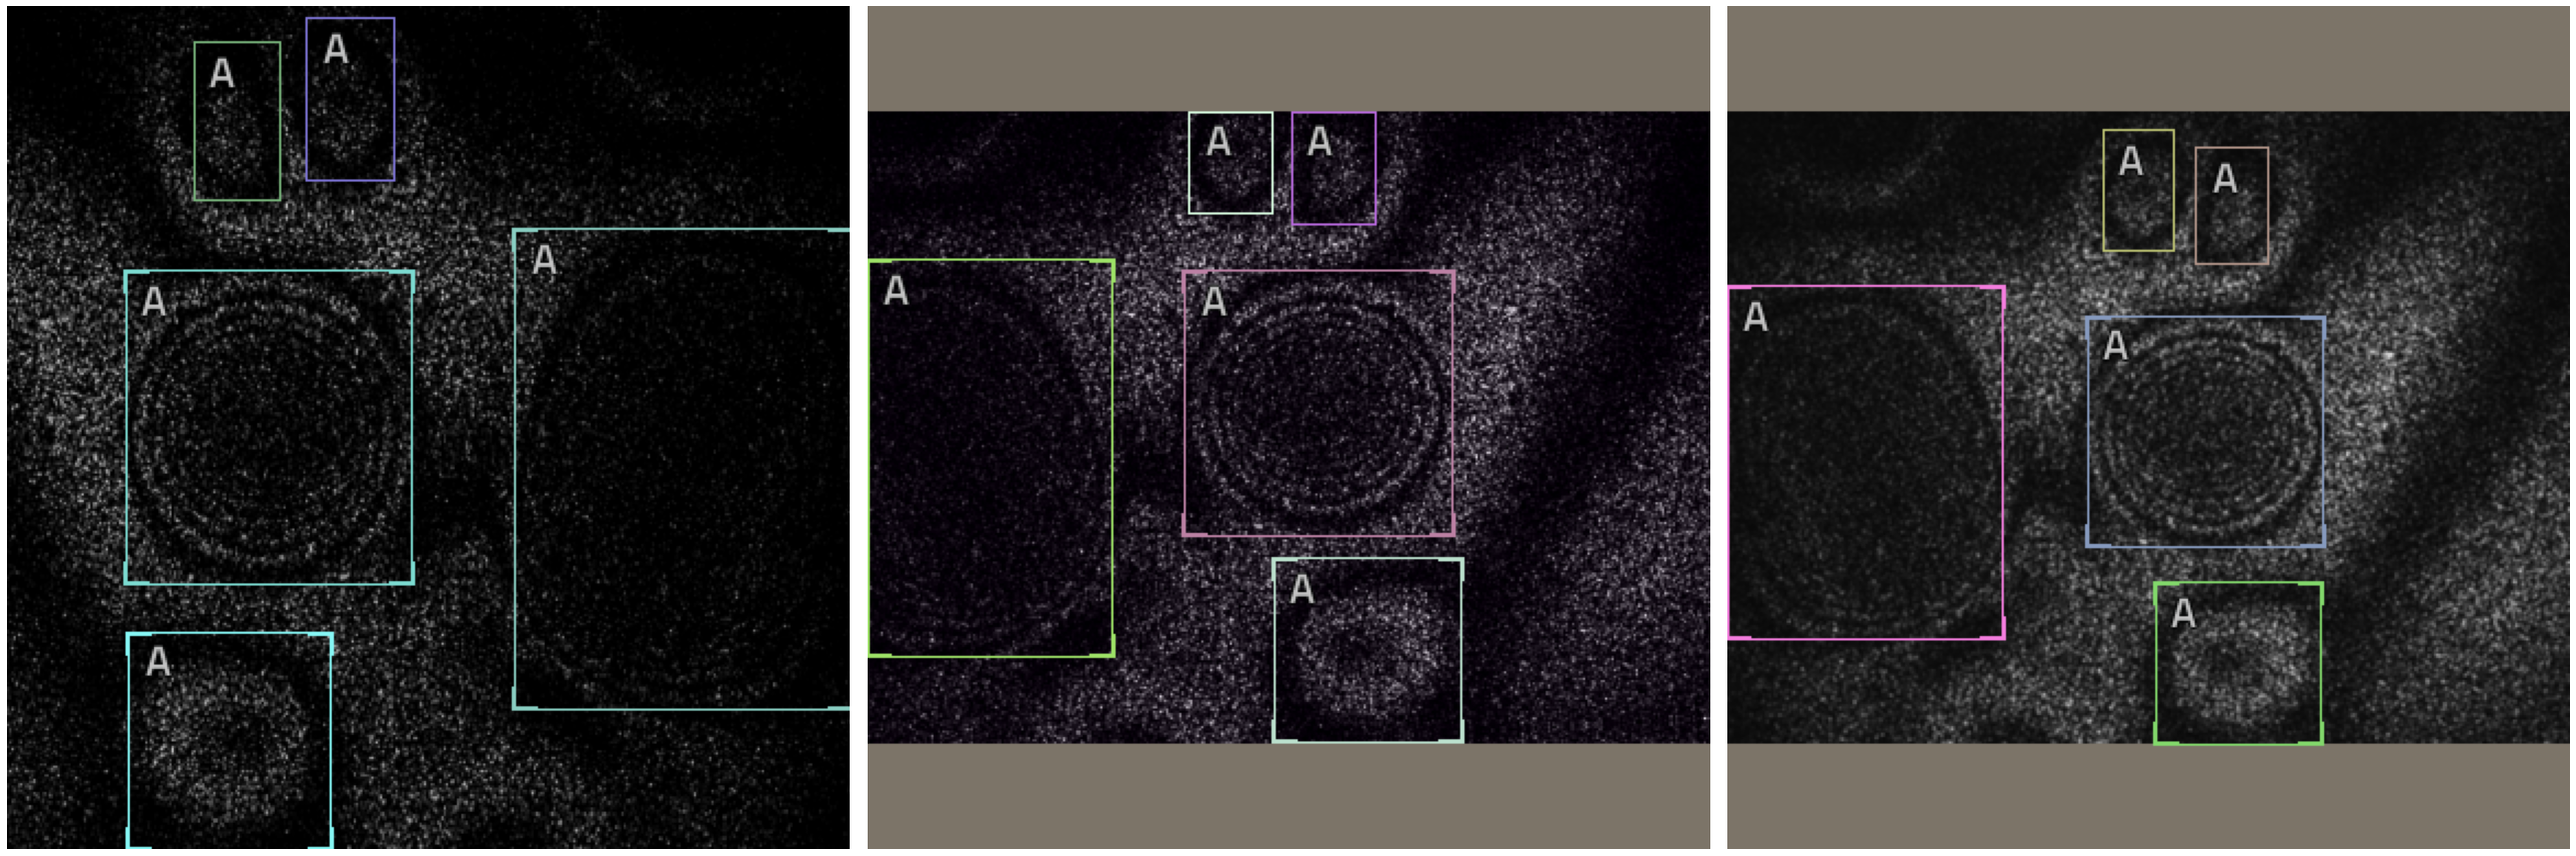

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

In [ ]:
# Just change the value of selection to try another model

selection = 0


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/home/shawley/envs/icevision/lib/python3.9/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})

In [ ]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

/home/shawley/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([9, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([9]).


In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

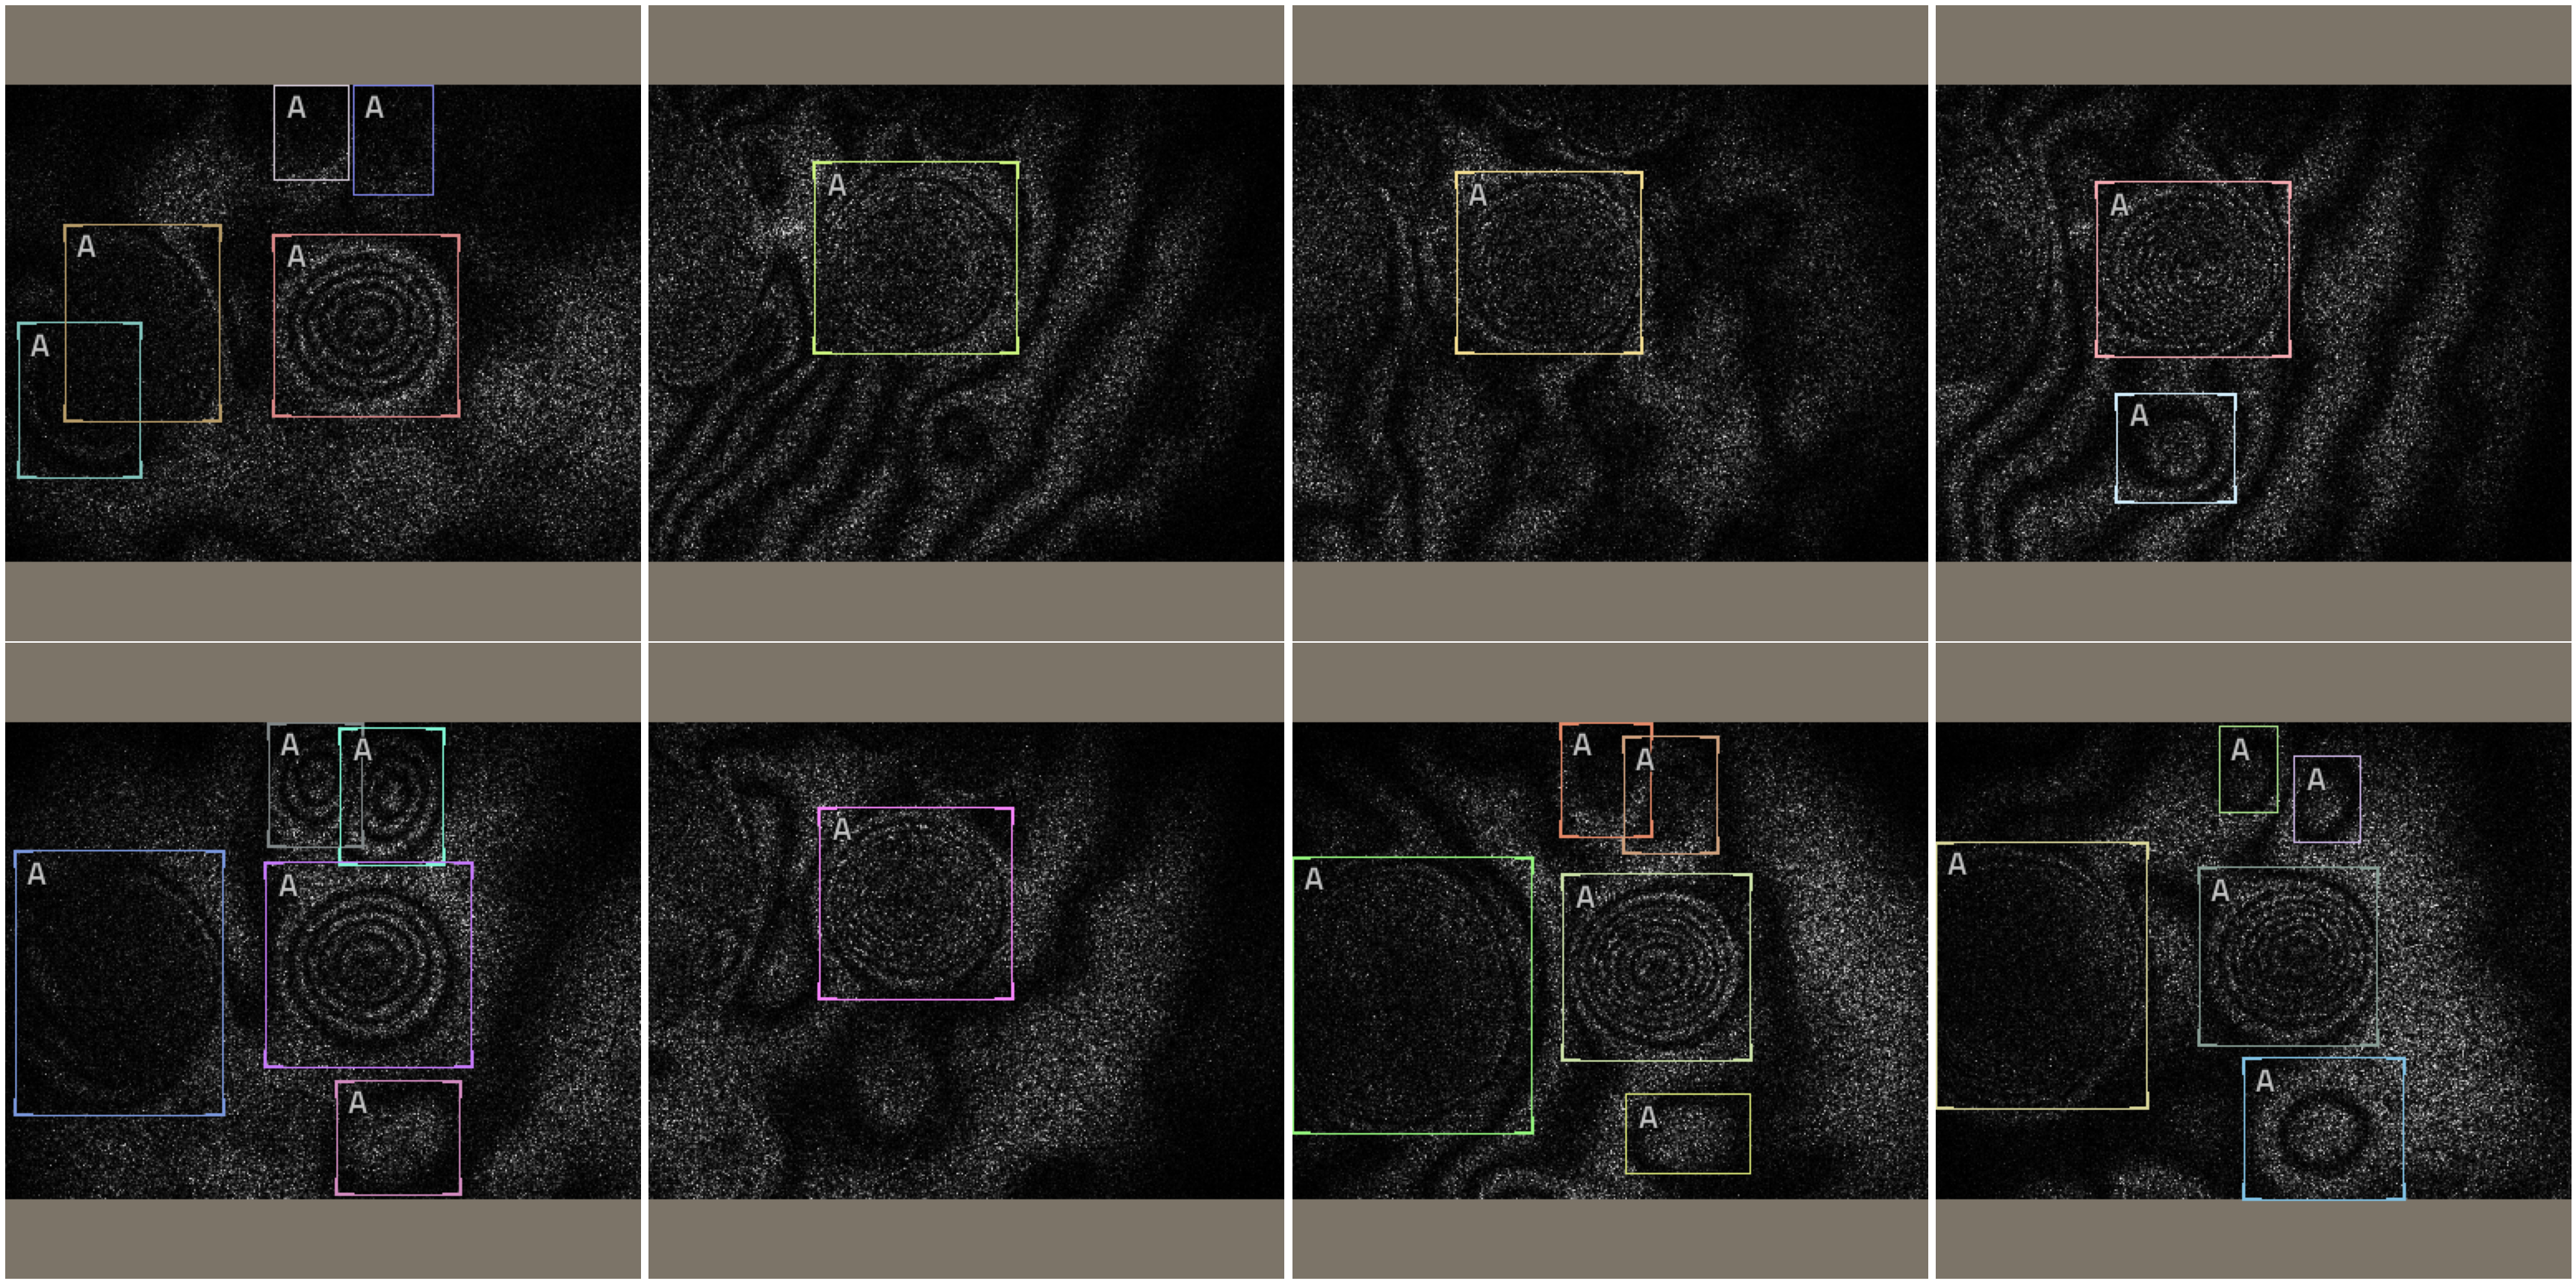

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
#i'm more familiar with fastai than lighting, so we'll use the fastai bindings

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/home/shawley/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/shawley/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(lr_min=7.943282253108919e-05, lr_steep=6.30957365501672e-05)

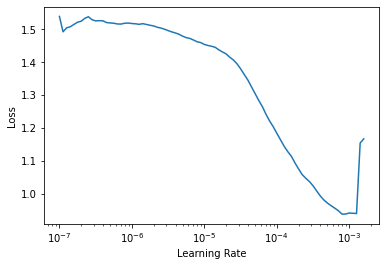

In [ ]:
learn.lr_find(end_lr=0.01)

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
learn.fine_tune(60, 1e-4, freeze_epochs=2)

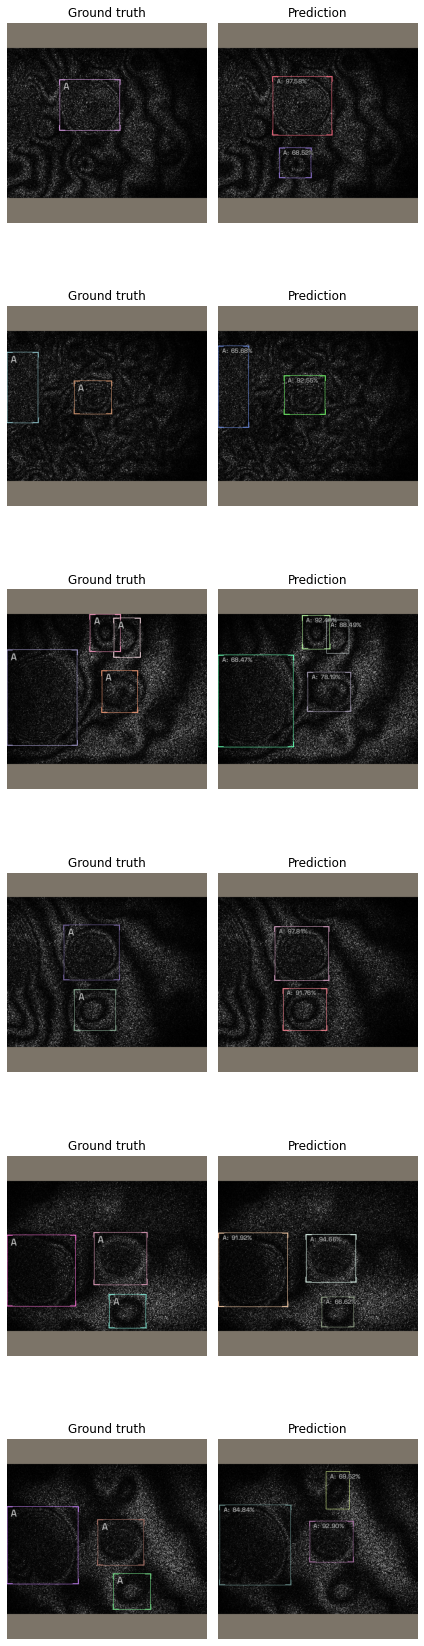

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
# milestone
learn.save('iv_bbox_real')
learn.load('iv_bbox_real'); 

## Predictions in bulk
Run through the whole dataset, do predictions on everything, write out bounding boxes, order by top losses

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

NameError: name 'infer_ds' is not defined

In [ ]:
preds = model_type.predict(model, infer_ds, keep_images=True)

TypeError: loss_fn() got an unexpected keyword argument 'reduction'

In [ ]:
learn.predict()

TypeError: predict() missing 1 required positional argument: 'item'

## Follow-up:

 [IceVision forum](https://discord.gg/JDBeZYK).